#**Redes Convolucionales**

El propósito del presente ejemplo es demostrar la implementación de las redes convolucionales a través de Pytorch, una de las librerías más populares en este contexto. Iniciaremos con la inclusión de las librerías necesarias para el ejercicio.

In [ ]:
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

Ahora definiremos los hiperparámetros fundamentales del ejercicio. Aquí definiremos cuántos elementos componen el set de entrenamiento y validación

In [ ]:
batch_size_train = 32
batch_size_test = 1000

random_seed = 1
torch.manual_seed(random_seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Emplearemos el dataset MNIST para nuestro ejemplo.

In [ ]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

Extracting /files/MNIST/raw/train-images-idx3-ubyte.gz to /files/MNIST/raw


Extracting /files/MNIST/raw/train-labels-idx1-ubyte.gz to /files/MNIST/raw


Extracting /files/MNIST/raw/t10k-images-idx3-ubyte.gz to /files/MNIST/raw


Extracting /files/MNIST/raw/t10k-labels-idx1-ubyte.gz to /files/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Visualicemos algunas imágenes del dataset

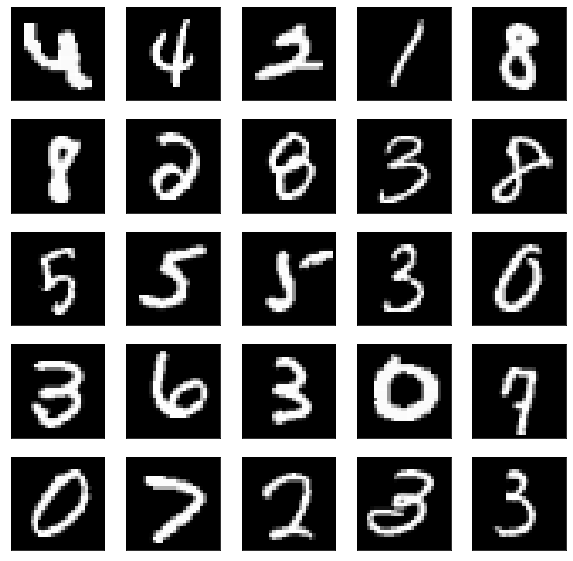

In [ ]:
_, ax = plt.subplots(5, 5, figsize=(10, 10))
index = 0
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

for i in range(5):
    for j in range(5):
        cell = ax[i][j]
        cell.set_xticks([])
        cell.set_yticks([])
        cell.grid(False)
        cell.imshow(example_data[index][0], cmap='gray')
        index += 1
        
plt.show()

Ahora crearemos la arquitectura de la red convolucional para clasificar el dataset.

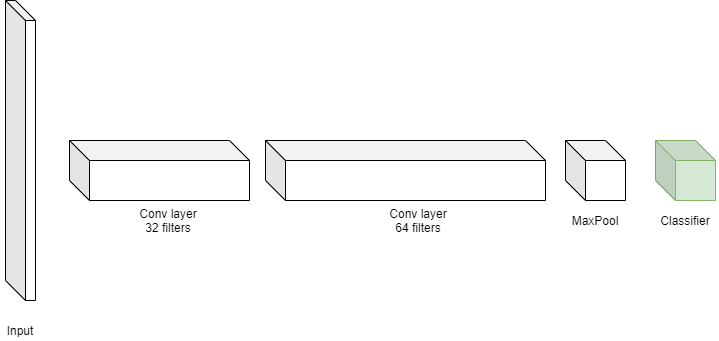

In [ ]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.maxpool1 = nn.MaxPool2d(2)
        self.dropout = nn.Dropout()

        self.fc1 = nn.Linear(9216, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, input):
        x = F.relu(self.conv1(input))
        x = F.relu(self.conv2(x))
        x = self.maxpool1(x)
        x = self.dropout(x)

        x = x.view(x.shape[0], -1)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        return x

Ahora instanciaremos el modelo, el loss function a emplear, y también el método de optimización

In [ ]:
model = ConvNet()
model.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

Función para evaluar el modelo

In [ ]:
def evaluate(probs, labels, loader):
    _, top_class = torch.max(probs, dim=1)
                
    equals = top_class == labels.view(*top_class.shape)
    accuracy = torch.sum(equals.type(torch.FloatTensor)).item()
    
    return accuracy / len(top_class)

Función para crear una copia del mejor modelo

In [ ]:
def checkpoint_model():
    checkpoint = {
              'model': model,
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              'criterion': criterion
    }

    torch.save(checkpoint, 'best_model.pth')

######Entrenamiento del modelo

In [ ]:
def train(n_epochs):
    print_every = 200
    train_losses = []
    train_counter = []
    val_losses = []
    test_counter = []
    max_test_accuracy = 0

    for epoch in range(n_epochs):
        steps = 0
        train_loss = 0
        train_accuracy = 0
        n_train_passes = 0
        
        model.train()
        print("#### TURNING TO TRAINING MODE ####")
        
        for inputs, labels in train_loader:
            steps += 1
            # Move input and label tensors to the default device
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            
            logps = model(inputs)
            
            loss = criterion(logps, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_accuracy += evaluate(logps, labels, train_loader)
            
            if steps % print_every == 0:
                print(f"Epoch {epoch+1}/{n_epochs}.. "
                      #f"Train loss: {running_loss/print_every:.3f}.. "
                      f"Train loss: {train_loss/n_train_passes:.3f}.. ")
                
            n_train_passes += 1
            
        print("Epoch " + str(epoch+1) + " Train loss {:.3f} ".format(train_loss/n_train_passes) + " train accuracy {:.3f}".format(train_accuracy * 100 / n_train_passes) + "%")
        train_losses.append(train_loss / n_train_passes)
            
        test_loss = 0
        test_accuracy = 0.0
        steps_test = 0
        n_test_passes = 0
        model.eval()
        
        print("#### TURNING TO EVALUATION MODE ####")
        
        with torch.no_grad():
            for val_inputs, val_labels in test_loader:
                steps_test += 1
                
                val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
                logps = model(val_inputs)
                    
                batch_loss = criterion(logps, val_labels)
                    
                test_loss += batch_loss.item()
                test_accuracy += evaluate(logps, val_labels, test_loader)

                if steps_test % print_every == 0:    
                    print(f"Epoch {epoch+1}/{n_epochs}.. "
                          #f"Train loss: {running_loss/print_every:.3f}.. "
                          f"Test loss: {test_loss/n_test_passes:.3f}.. ")
                
                
                running_loss = 0
                n_test_passes += 1
                
        test_accuracy = test_accuracy * 100 / n_test_passes
        
        if test_accuracy > max_test_accuracy:
            checkpoint_model()
            max_test_accuracy = test_accuracy
                
        print("Epoch " + str(epoch+1) + " Train loss {:.3f} ".format(test_loss/n_test_passes) + " val accuracy {:.3f}".format(test_accuracy) + "%")
        val_losses.append(test_loss / n_test_passes)

    return train_losses, val_losses

Proceso de entrenamiento del modelo

In [ ]:
train_losses, val_losses = train(5)

#### TURNING TO TRAINING MODE ####
Epoch 1/5.. Train loss: 1.210.. 
Epoch 1/5.. Train loss: 0.915.. 
Epoch 1/5.. Train loss: 0.803.. 
Epoch 1/5.. Train loss: 0.741.. 
Epoch 1/5.. Train loss: 0.695.. 
Epoch 1/5.. Train loss: 0.657.. 
Epoch 1/5.. Train loss: 0.629.. 
Epoch 1/5.. Train loss: 0.606.. 
Epoch 1/5.. Train loss: 0.583.. 
Epoch 1 Train loss 0.575  train accuracy 81.470%
#### TURNING TO EVALUATION MODE ####
Epoch 1 Train loss 0.356  val accuracy 87.080%
#### TURNING TO TRAINING MODE ####
Epoch 2/5.. Train loss: 0.245.. 
Epoch 2/5.. Train loss: 0.201.. 
Epoch 2/5.. Train loss: 0.190.. 
Epoch 2/5.. Train loss: 0.180.. 
Epoch 2/5.. Train loss: 0.172.. 
Epoch 2/5.. Train loss: 0.166.. 
Epoch 2/5.. Train loss: 0.159.. 
Epoch 2/5.. Train loss: 0.155.. 
Epoch 2/5.. Train loss: 0.150.. 
Epoch 2 Train loss 0.148  train accuracy 95.473%
#### TURNING TO EVALUATION MODE ####
Epoch 2 Train loss 0.080  val accuracy 97.540%
#### TURNING TO TRAINING MODE ####
Epoch 3/5.. Train loss: 0.095.. 
Ep

######Graficación de la función de error

In [ ]:
def plot_loss(train_losses, val_losses):
    epochs = np.linspace(1, len(val_losses), len(val_losses))

    plt.figure(figsize=(10, 10))
    plt.plot(epochs, train_losses, label='Train loss')
    plt.plot(epochs, val_losses, label='Validation loss')
    plt.legend()
    plt.grid(True)
    plt.show()

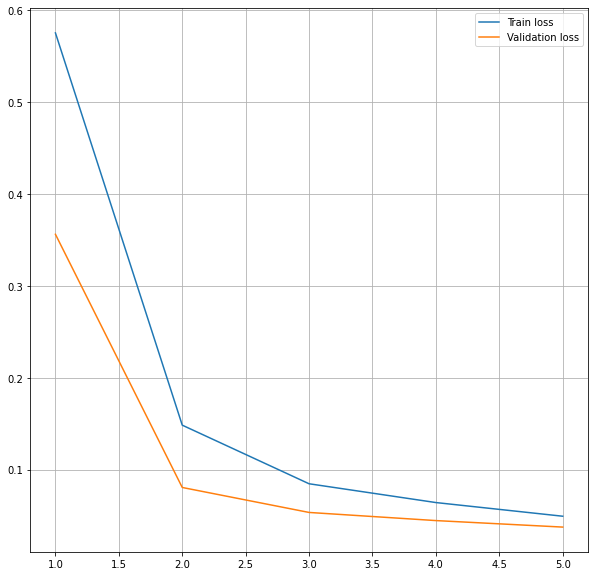

In [ ]:
plot_loss(train_losses, val_losses)

Ahora probaremos con algunas imágenes del dataset

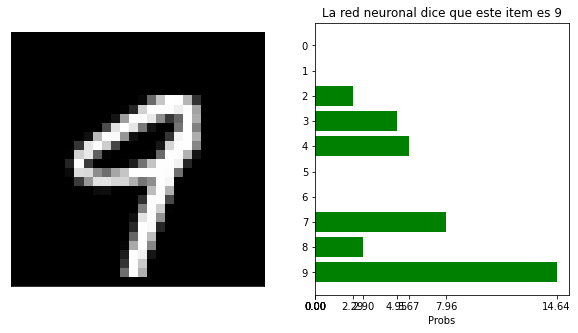

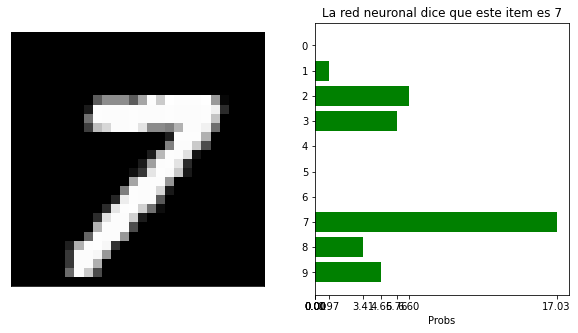

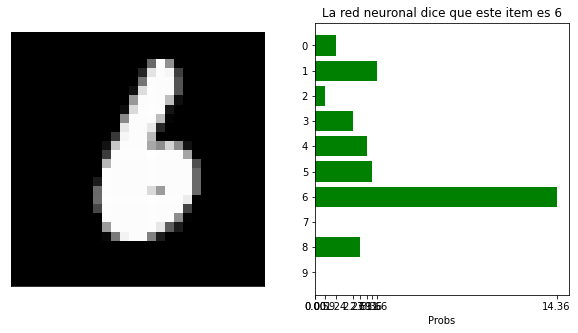

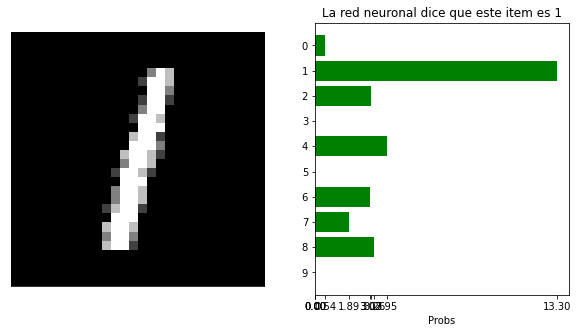

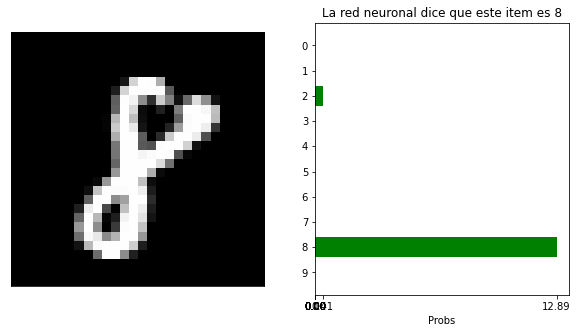

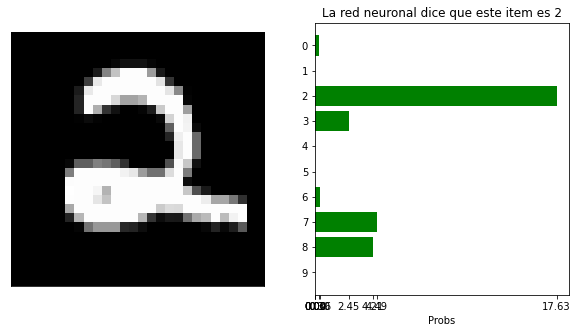

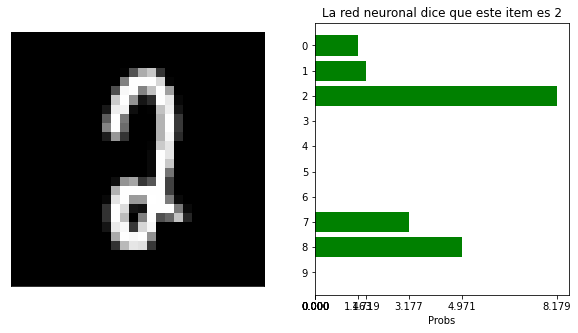

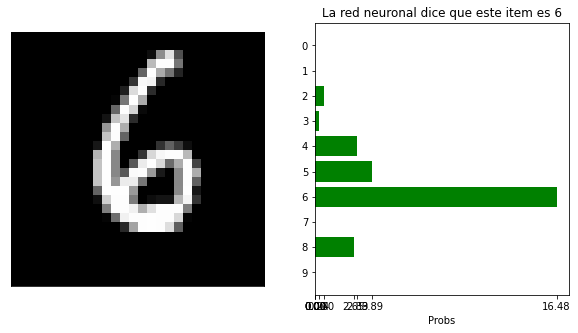

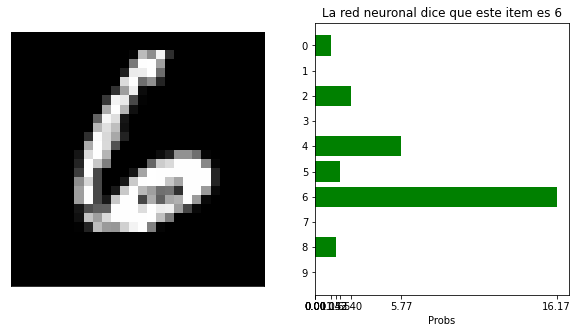

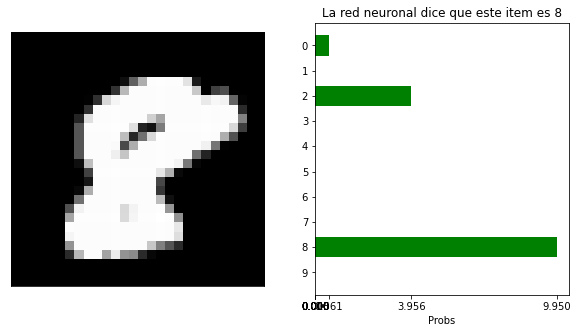

In [ ]:
def classify(classes, example_data, idx):
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.imshow(example_data[idx][0], cmap='gray')
    ax1.get_yaxis().set_visible(False)
    ax1.get_xaxis().set_visible(False)
    
    probs = model(example_data[idx][0].reshape(1, 1, 28, 28).to('cuda'))
    probs = probs.cpu().detach().numpy()
    predicted = np.argmax(probs)
    
    yticks = np.arange(10)
    
    ax2.barh(classes, width=probs[0], align='center', color='green', ecolor='black')
    ax2.set_xticks(probs[0])
    ax2.set_yticks(yticks)
    ax2.invert_yaxis()
    ax2.set_xlabel('Probs')
    ax2.set_title('Probabilities')
    
    plt.title("La red neuronal dice que este item es " + str(classes[predicted]))
    plt.show()

classes = np.arange(0, 10)
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

for i in range(10):
    classify(classes, example_data, i)

# Segunda parte

Ahora repetiremos el mismo procedimiento pero con un dataset llamado Fashion MNIST. Es un dataset un poco más complejo que el anterior y contiene imágenes de prendas de vestir.

In [ ]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.FashionMNIST('/files-fashion/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.FashionMNIST('/files-fashion/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

Extracting /files-fashion/FashionMNIST/raw/train-images-idx3-ubyte.gz to /files-fashion/FashionMNIST/raw


Extracting /files-fashion/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /files-fashion/FashionMNIST/raw




Extracting /files-fashion/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /files-fashion/FashionMNIST/raw


Extracting /files-fashion/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /files-fashion/FashionMNIST/raw
Processing...
Done!


Algunas imágenes del dataset

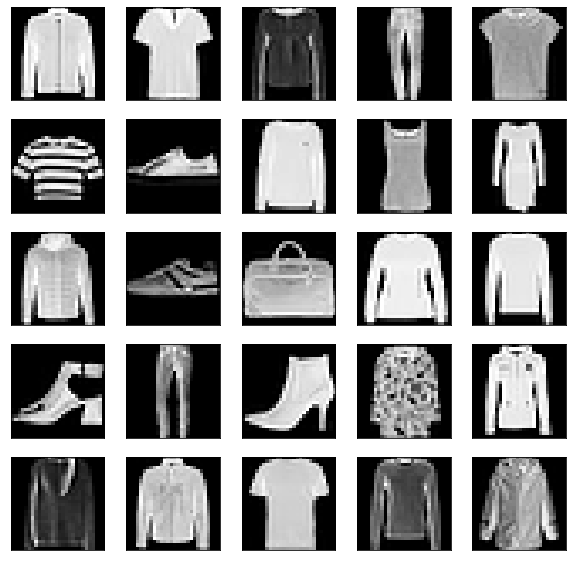

In [ ]:
_, ax = plt.subplots(5, 5, figsize=(10, 10))
index = 0
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

for i in range(5):
    for j in range(5):
        cell = ax[i][j]
        cell.set_xticks([])
        cell.set_yticks([])
        cell.grid(False)
        cell.imshow(example_data[index][0], cmap='gray')
        index += 1
        
plt.show()

Arquitectura de la red convolucional

In [ ]:
class FashionConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.maxpool1 = nn.MaxPool2d(2)
        self.dropout1 = nn.Dropout()

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.maxpool2 = nn.MaxPool2d(2)
        self.dropout2 = nn.Dropout()

        self.fc1 = nn.Linear(9216, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, input):
        x = F.relu(self.conv1(input))
        x = self.maxpool1(x)
        x = self.dropout1(x)

        x = F.relu(self.conv2(x))
        x = self.maxpool2(x)
        x = self.dropout2(x)
        
        x = x.view(x.shape[0], -1)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        return x

Instanciación de la red convolucional y loss function

In [ ]:
model = ConvNet()
model.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

Entrenamiento

In [ ]:
train_losses, val_losses = train(20)

#### TURNING TO TRAINING MODE ####
Epoch 1/20.. Train loss: 1.416.. 
Epoch 1/20.. Train loss: 1.203.. 
Epoch 1/20.. Train loss: 1.050.. 
Epoch 1/20.. Train loss: 0.940.. 
Epoch 1/20.. Train loss: 0.872.. 
Epoch 1/20.. Train loss: 0.815.. 
Epoch 1/20.. Train loss: 0.770.. 
Epoch 1/20.. Train loss: 0.734.. 
Epoch 1/20.. Train loss: 0.706.. 
Epoch 1 Train loss 0.697  train accuracy 74.548%
#### TURNING TO EVALUATION MODE ####
Epoch 1 Train loss 0.447  val accuracy 83.930%
#### TURNING TO TRAINING MODE ####
Epoch 2/20.. Train loss: 0.435.. 
Epoch 2/20.. Train loss: 0.435.. 
Epoch 2/20.. Train loss: 0.435.. 
Epoch 2/20.. Train loss: 0.426.. 
Epoch 2/20.. Train loss: 0.420.. 
Epoch 2/20.. Train loss: 0.413.. 
Epoch 2/20.. Train loss: 0.412.. 
Epoch 2/20.. Train loss: 0.411.. 
Epoch 2/20.. Train loss: 0.408.. 
Epoch 2 Train loss 0.406  train accuracy 85.393%
#### TURNING TO EVALUATION MODE ####
Epoch 2 Train loss 0.373  val accuracy 86.460%
#### TURNING TO TRAINING MODE ####
Epoch 3/20.. Trai

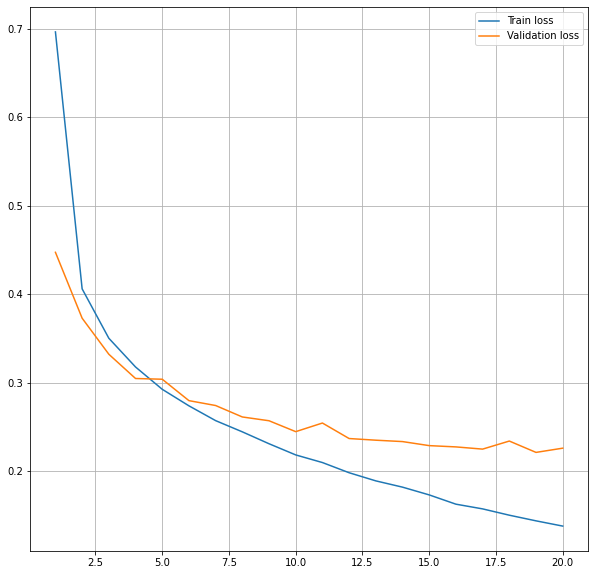

In [ ]:
plot_loss(train_losses, val_losses)

Clasificación

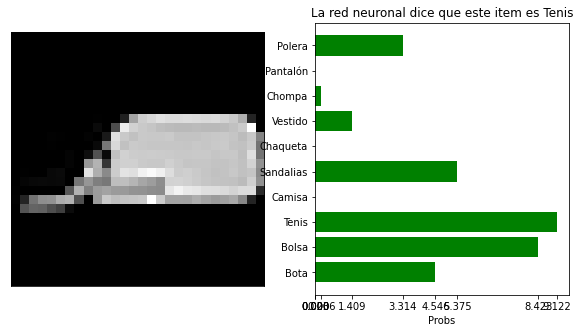

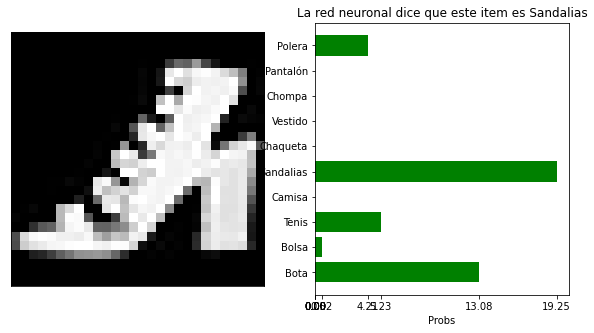

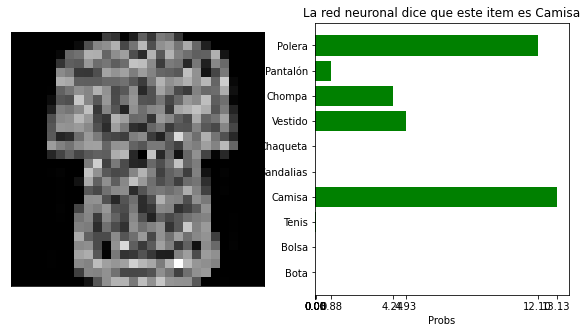

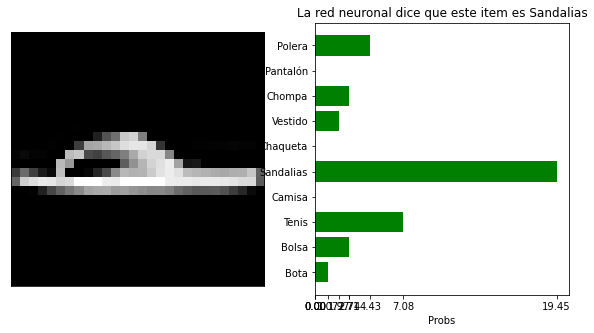

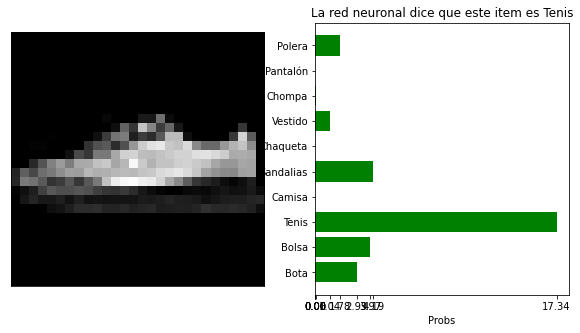

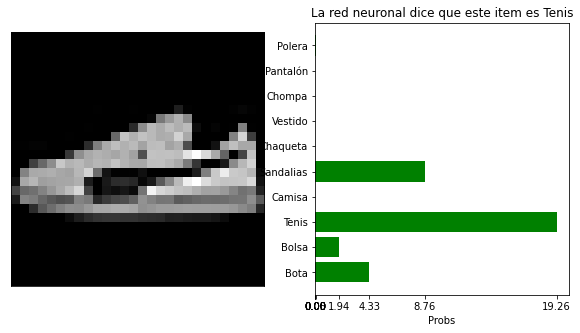

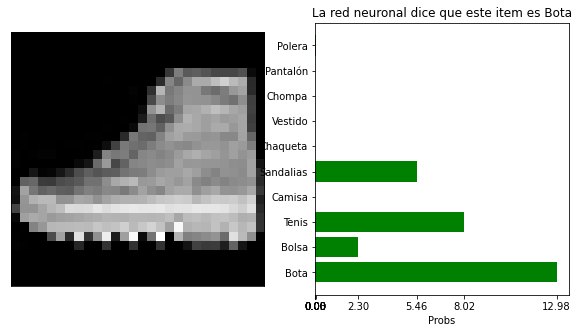

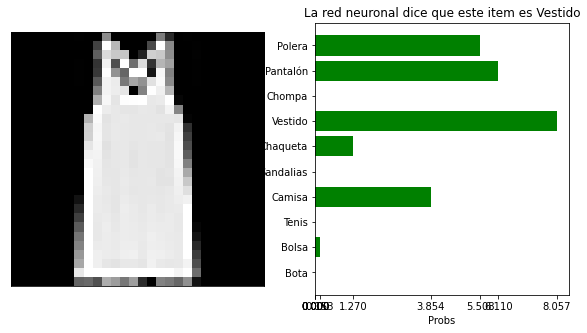

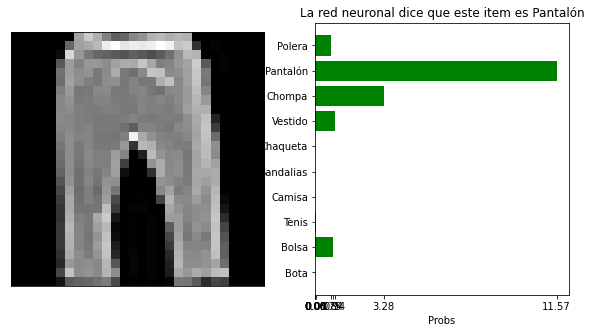

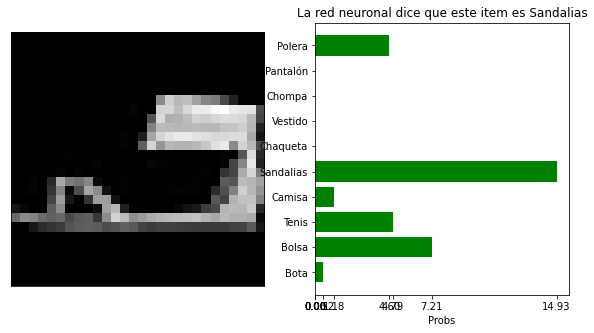

In [ ]:
classes = ['Polera', 'Pantalón', 'Chompa', 'Vestido', 'Chaqueta', 'Sandalias', 'Camisa', 'Tenis', 'Bolsa', 'Bota']
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

for i in range(10):
    classify(classes, example_data, i)